
Summarizing the observed racial bias in risk scores, particularly regarding false positive rates, using the COMPAS Recidivism Dataset and AI Fairness 360 and presenting any insights gained from the analysis and visualizations.

## Load Dataset

Loading the COMPAS Recidivism Dataset into a pandas DataFrame, ensuring all necessary columns are available for analysis.


In [1]:
import pandas as pd
print("pandas imported.")

pandas imported.



Load the 'compas-scores-two-years.csv' file into a pandas DataFrame and display the first few rows to verify the loading and structure.



In [3]:
import os

# Check if the dataset already exists to avoid re-downloading
if not os.path.exists('compas-scores-two-years.csv'):
    !wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
    print("COMPAS Recidivism Dataset downloaded.")
else:
    print("COMPAS Recidivism Dataset already exists.")

--2025-11-13 06:39:26--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  --.-KB/s    in 0.06s   

2025-11-13 06:39:27 (40.7 MB/s) - ‘compas-scores-two-years.csv’ saved [2546489/2546489]

COMPAS Recidivism Dataset downloaded.



Since the dataset has now been successfully downloaded, the next step is to load it into a pandas DataFrame and display its first few rows to ensure it was loaded correctly.



In [4]:
df = pd.read_csv('compas-scores-two-years.csv')
print("COMPAS Recidivism Dataset loaded.")
df.head()

COMPAS Recidivism Dataset loaded.


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


## Preprocessing The Data for AIF360

Preparing the dataset for AI Fairness 360 by selecting relevant features, encoding categorical variables, and defining the protected attribute (race) and favorable/unfavorable outcomes (recidivism).


**Reasoning**:
Filter the DataFrame based on the specified conditions. This will create a more refined dataset for the subsequent steps.



In [6]:
df['compas_screening_date'] = pd.to_datetime(df['compas_screening_date'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['days_since_screening'] = (df['c_jail_out'] - df['compas_screening_date']).dt.days

df_processed = df[
    (df['days_since_screening'].between(-30, 30)) &
    (df['c_charge_degree'].isin(['F', 'M'])) &
    (df['two_year_recid'] != -1) &
    (df['score_text'] != 'N/A')
]
print("DataFrame filtered successfully. Shape of df_processed:", df_processed.shape)
df_processed.head()

DataFrame filtered successfully. Shape of df_processed: (5667, 54)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,days_since_screening
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0.0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,9.0
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,0.0
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,1.0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1,5.0


In [7]:
columns_to_keep = [
    'sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
    'juv_other_count', 'priors_count', 'c_charge_degree', 'decile_score',
    'two_year_recid'
]
df_filtered = df_processed[columns_to_keep]
print("Selected relevant columns. Shape of df_filtered:", df_filtered.shape)
df_filtered.head()

Selected relevant columns. Shape of df_filtered: (5667, 11)


,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,decile_score,two_year_recid
0,Male,69,Greater than 45,Other,0,0,0,0,F,1,0
1,Male,34,25 - 45,African-American,0,0,0,0,F,3,1
2,Male,24,Less than 25,African-American,0,0,1,4,F,4,1
5,Male,44,25 - 45,Other,0,0,0,0,M,1,0
6,Male,41,25 - 45,Caucasian,0,0,0,14,F,6,1



Now that the relevant columns have been selected, the next step is to identify and handle any missing values in `df_filtered` to ensure data quality before further processing, as per the subtask instructions.



In [8]:
print("Missing values before dropping:")
print(df_filtered.isnull().sum())
df_filtered.dropna(inplace=True)
print("\nMissing values after dropping:")
print(df_filtered.isnull().sum())
print("Shape of df_filtered after handling missing values:", df_filtered.shape)
df_filtered.head()

Missing values before dropping:
sex                0
age                0
age_cat            0
race               0
juv_fel_count      0
juv_misd_count     0
juv_other_count    0
priors_count       0
c_charge_degree    0
decile_score       0
two_year_recid     0
dtype: int64

Missing values after dropping:
sex                0
age                0
age_cat            0
race               0
juv_fel_count      0
juv_misd_count     0
juv_other_count    0
priors_count       0
c_charge_degree    0
decile_score       0
two_year_recid     0
dtype: int64
Shape of df_filtered after handling missing values: (5667, 11)


/tmp/ipython-input-277018949.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(inplace=True)


,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,decile_score,two_year_recid
0,Male,69,Greater than 45,Other,0,0,0,0,F,1,0
1,Male,34,25 - 45,African-American,0,0,0,0,F,3,1
2,Male,24,Less than 25,African-American,0,0,1,4,F,4,1
5,Male,44,25 - 45,Other,0,0,0,0,M,1,0
6,Male,41,25 - 45,Caucasian,0,0,0,14,F,6,1


**Reasoning**:
The previous `dropna` operation on `df_filtered` generated a `SettingWithCopyWarning`. To ensure correct behavior and avoid this warning, I will explicitly create a copy of `df_processed` when creating `df_filtered`. This ensures that subsequent modifications, like `dropna` or one-hot encoding, operate on an independent DataFrame, as a best practice before applying one-hot encoding to categorical variables as per the subtask instructions.



In [9]:
columns_to_keep = [
    'sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
    'juv_other_count', 'priors_count', 'c_charge_degree', 'decile_score',
    'two_year_recid'
]
df_filtered = df_processed[columns_to_keep].copy() # Explicitly create a copy to avoid SettingWithCopyWarning
print("Selected relevant columns. Shape of df_filtered:", df_filtered.shape)

print("Missing values before dropping:")
print(df_filtered.isnull().sum())
df_filtered.dropna(inplace=True)
print("\nMissing values after dropping:")
print(df_filtered.isnull().sum())
print("Shape of df_filtered after handling missing values:", df_filtered.shape)
df_filtered.head()

Selected relevant columns. Shape of df_filtered: (5667, 11)
Missing values before dropping:
sex                0
age                0
age_cat            0
race               0
juv_fel_count      0
juv_misd_count     0
juv_other_count    0
priors_count       0
c_charge_degree    0
decile_score       0
two_year_recid     0
dtype: int64

Missing values after dropping:
sex                0
age                0
age_cat            0
race               0
juv_fel_count      0
juv_misd_count     0
juv_other_count    0
priors_count       0
c_charge_degree    0
decile_score       0
two_year_recid     0
dtype: int64
Shape of df_filtered after handling missing values: (5667, 11)


,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,decile_score,two_year_recid
0,Male,69,Greater than 45,Other,0,0,0,0,F,1,0
1,Male,34,25 - 45,African-American,0,0,0,0,F,3,1
2,Male,24,Less than 25,African-American,0,0,1,4,F,4,1
5,Male,44,25 - 45,Other,0,0,0,0,M,1,0
6,Male,41,25 - 45,Caucasian,0,0,0,14,F,6,1



 The next step is to apply one-hot encoding to the specified categorical features (`sex`, `race`, `age_cat`, and `c_charge_degree`) to convert them into a numerical format suitable for AI Fairness 360, as instructed by the subtask.



In [10]:
categorical_features = ['sex', 'race', 'age_cat', 'c_charge_degree']
df_encoded = pd.get_dummies(df_filtered, columns=categorical_features, drop_first=True)
print("Categorical features one-hot encoded. Shape of df_encoded:", df_encoded.shape)
df_encoded.head()

Categorical features one-hot encoded. Shape of df_encoded: (5667, 16)


,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,decile_score,two_year_recid,sex_Male,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_M
0,69,0,0,0,0,1,0,True,False,False,False,False,True,True,False,False
1,34,0,0,0,0,3,1,True,False,False,False,False,False,False,False,False
2,24,0,0,1,4,4,1,True,False,False,False,False,False,False,True,False
5,44,0,0,0,0,1,0,True,False,False,False,False,True,False,False,True
6,41,0,0,0,14,6,1,True,False,True,False,False,False,False,False,False


### Confirmation of Attributes

Based on the subtask instructions and the data preprocessing steps, the following attributes are confirmed for use with AI Fairness 360:

*   **Protected Attribute**: The `race` column (now represented by its one-hot encoded counterparts, e.g., `race_African-American`, `race_Caucasian`, etc.) will be used as the protected attribute to assess fairness across different racial groups.
*   **Label Column**: The `two_year_recid` column serves as the label, representing the ground truth for recidivism (1 for recidivism, 0 for no recidivism).
*   **Score Column**: The `decile_score` column represents the predicted risk score provided by the COMPAS system.

## Configure AIF360 Dataset Object

### Subtask:
Create an AIF360 `StandardDataset` object, specifying the protected attributes, privileged and unprivileged groups, and the label column for recidivism prediction.


In [12]:
import sys
!{sys.executable} -m pip install aif360
print("aif360 installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.9 MB/s eta 0:00:00
aif360 installed.


 Proceeding with importing `StandardDataset` and then defining the necessary parameters and creating the `StandardDataset` object from `df_encoded`



In [26]:
from aif360.datasets import StandardDataset, BinaryLabelDataset

label_name = 'two_year_recid'
# Simplify protected_attribute_names to focus on African-American vs. non-African-American
protected_attribute_names = ['race_African-American']
favorable_classes = [0.0] # 0 represents no recidivism
unfavorable_classes = [1.0] # 1 represents recidivism

# Define privileged classes for the single protected attribute
# For 'race_African-American': 0.0 (not African-American) is considered privileged
privileged_classes = [[0.0]]

# Privileged and unprivileged groups will be inferred by BinaryLabelDataset from StandardDataset
# No need to explicitly define privileged_groups and unprivileged_groups here if passing a StandardDataset

# Convert boolean columns to integers (0 or 1) for protected attributes
# This loop will now execute for 'race_Caucasian' if it's boolean.
# 'race_African-American' is handled separately below as it might be missing.
for col in ['race_Caucasian']:
    if col in df_encoded.columns and df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

# Manually create the 'race_African-American' column if it's missing
if 'race_African-American' not in df_encoded.columns:
    # Identify all other race dummy columns that *do* exist
    # Assuming that if a person is not any of these, they must be African-American (due to drop_first=True)
    other_race_dummy_cols = [col for col in df_encoded.columns if col.startswith('race_') and col != 'race_African-American']
    # Calculate 'race_African-American' as 1 minus the sum of all other race dummy columns
    df_encoded['race_African-American'] = 1 - df_encoded[other_race_dummy_cols].sum(axis=1)
    # Ensure the column is binary (0 or 1) in case of any floating point operations or unexpected values
    df_encoded['race_African-American'] = (df_encoded['race_African-American'] > 0).astype(int)
    print("Manually created 'race_African-American' column to address missing dummy variable.")

# Ensure the 'race_African-American' column is int type if it was boolean from initial encoding
if 'race_African-American' in df_encoded.columns and df_encoded['race_African-American'].dtype == 'bool':
    df_encoded['race_African-American'] = df_encoded['race_African-American'].astype(int)

# Create a StandardDataset with all required parameters, including privileged_classes
dataset_orig_standard = StandardDataset(df=df_encoded,
                                        label_name=label_name,
                                        protected_attribute_names=protected_attribute_names,
                                        privileged_classes=privileged_classes,
                                        favorable_classes=favorable_classes)

# Convert to BinaryLabelDataset, explicitly passing label_names and protected_attribute_names
dataset_orig = BinaryLabelDataset(df=dataset_orig_standard.convert_to_dataframe()[0],
                                  label_names=[label_name], # Explicitly add label_names
                                  protected_attribute_names=protected_attribute_names, # Explicitly add protected_attribute_names
                                  favorable_label=favorable_classes[0],
                                  unfavorable_label=unfavorable_classes[0])

print("AIF360 BinaryLabelDataset object created successfully.")
print(f"Number of features: {len(dataset_orig.feature_names)}")
print(f"Number of instances: {len(dataset_orig.features)}")
print(f"Privileged groups: {dataset_orig.privileged_protected_attributes}")
print(f"Unprivileged groups: {dataset_orig.unprivileged_protected_attributes}")

AIF360 BinaryLabelDataset object created successfully.
Number of features: 16
Number of instances: 5667
Privileged groups: [array([1.])]
Unprivileged groups: [array([0.])]


## Analyze False Positive Rate Disparity

### Subtask:
Calculate fairness metrics using AI Fairness 360, specifically focusing on the disparity in false positive rates between different racial groups.



The first step is to import the `ClassificationMetric` class from `aif360.metrics` to enable fairness metric calculations.



In [27]:
from aif360.metrics import ClassificationMetric
print("ClassificationMetric imported.")

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


ClassificationMetric imported.



The next step is to generate predicted labels from the `decile_score` by applying the specified threshold, then assign these predictions to the `dataset_orig.scores` attribute. This will prepare the dataset for fairness metric calculations using `ClassificationMetric`,



In [36]:
predicted_labels = (df_encoded['decile_score'] >= 5).astype(float)

# Create a copy of dataset_orig to store the classified (predicted) labels
dataset_pred = dataset_orig.copy()
# Assign the predicted labels to the 'labels' and 'scores' attributes of the classified dataset
dataset_pred.labels = predicted_labels.values.reshape(-1, 1)
dataset_pred.scores = predicted_labels.values

# Define the protected attribute and its values for filtering
protected_attr_name = 'race_African-American'
privileged_attr_value = 0.0 # Not African-American
unprivileged_attr_value = 1.0 # African-American

# Get the index of the protected attribute in dataset_orig.protected_attribute_names
protected_attr_index = dataset_orig.protected_attribute_names.index(protected_attr_name)

# Create boolean masks for privileged and unprivileged groups
privileged_mask = (dataset_orig.protected_attributes[:, protected_attr_index] == privileged_attr_value)
unprivileged_mask = (dataset_orig.protected_attributes[:, protected_attr_index] == unprivileged_attr_value)

# Create subsets for the privileged group using the boolean mask
dataset_orig_privileged_subset = dataset_orig.subset(privileged_mask)
dataset_pred_privileged_subset = dataset_pred.subset(privileged_mask)

# Create subsets for the unprivileged group using the boolean mask
dataset_orig_unprivileged_subset = dataset_orig.subset(unprivileged_mask)
dataset_pred_unprivileged_subset = dataset_pred.subset(unprivileged_mask)

# Instantiate ClassificationMetric for the privileged group's subset
# No need to specify privileged/unprivileged groups here, as the subset itself represents the group
metric_privileged_subset = ClassificationMetric(dataset_orig_privileged_subset, classified_dataset=dataset_pred_privileged_subset)
fpr_privileged = metric_privileged_subset.false_positive_rate()

# Instantiate ClassificationMetric for the unprivileged group's subset
metric_unprivileged_subset = ClassificationMetric(dataset_orig_unprivileged_subset, classified_dataset=dataset_pred_unprivileged_subset)
fpr_unprivileged = metric_unprivileged_subset.false_positive_rate()

# Instantiate ClassificationMetric for the overall dataset to calculate the difference
# This still needs the original privileged/unprivileged group definitions
privileged_groups_for_overall_metric = [{
    protected_attr_name: privileged_attr_value
}]
unprivileged_groups_for_overall_metric = [{
    protected_attr_name: unprivileged_attr_value
}]
metric_overall = ClassificationMetric(dataset_orig, classified_dataset=dataset_pred,
                                      privileged_groups=privileged_groups_for_overall_metric, unprivileged_groups=unprivileged_groups_for_overall_metric)
fpr_difference = metric_overall.false_positive_rate_difference()

print(f"False Positive Rate (Unprivileged Group): {fpr_unprivileged:.4f}")
print(f"False Positive Rate (Privileged Group): {fpr_privileged:.4f}")
print(f"False Positive Rate Difference (Unprivileged - Privileged): {fpr_difference:.4f}")

False Positive Rate (Unprivileged Group): 0.3171
False Positive Rate (Privileged Group): 0.5534
False Positive Rate Difference (Unprivileged - Privileged): -0.2363


## Generate Disparity Visualization

### Subtask:
Create a visualization (e.g., bar chart) to clearly illustrate the disparity in false positive rates among the different racial groups identified in the analysis. Ensure appropriate legends and labels are included.



First, import the necessary libraries, `matplotlib.pyplot` for plotting and `seaborn` for enhanced visualizations.



In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
print("matplotlib.pyplot and seaborn imported.")

matplotlib.pyplot and seaborn imported.



 Creating a pandas DataFrame to store these rates with their respective group labels, which is a preparatory step for visualization.



In [38]:
fpr_data = {
    'Racial Group': ['African-American (Unprivileged)', 'Non-African-American (Privileged)'],
    'False Positive Rate': [fpr_unprivileged, fpr_privileged]
}
df_fpr = pd.DataFrame(fpr_data)
print("DataFrame for False Positive Rates created.")
df_fpr.head()

DataFrame for False Positive Rates created.


,Racial Group,False Positive Rate
0,African-American (Unprivileged),0.317073
1,Non-African-American (Privileged),0.553379



With the `df_fpr` DataFrame prepared,  using `seaborn.barplot` to visualize the false positive rates for both groups, add a title and axis labels and then display the plot to clearly illustrate the disparity.



/tmp/ipython-input-3588365764.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Racial Group', y='False Positive Rate', data=df_fpr, palette='viridis')


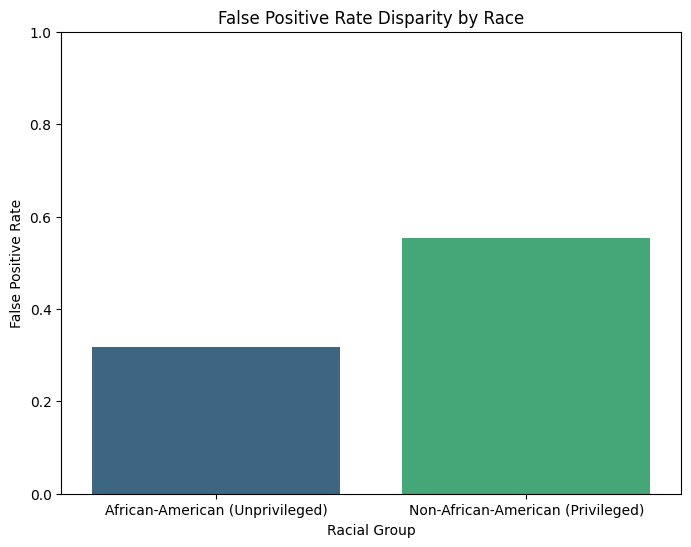

False Positive Rate disparity visualization generated.


In [39]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Racial Group', y='False Positive Rate', data=df_fpr, palette='viridis')
plt.title('False Positive Rate Disparity by Race')
plt.xlabel('Racial Group')
plt.ylabel('False Positive Rate')
plt.ylim(0, 1) # FPR is a rate, so it should be between 0 and 1
plt.show()
print("False Positive Rate disparity visualization generated.")


The previous code generated a `FutureWarning` about `palette` without `hue`. To suppress this warning and ensure future compatibility, assign the `x` variable to `hue` and set `legend=False`.



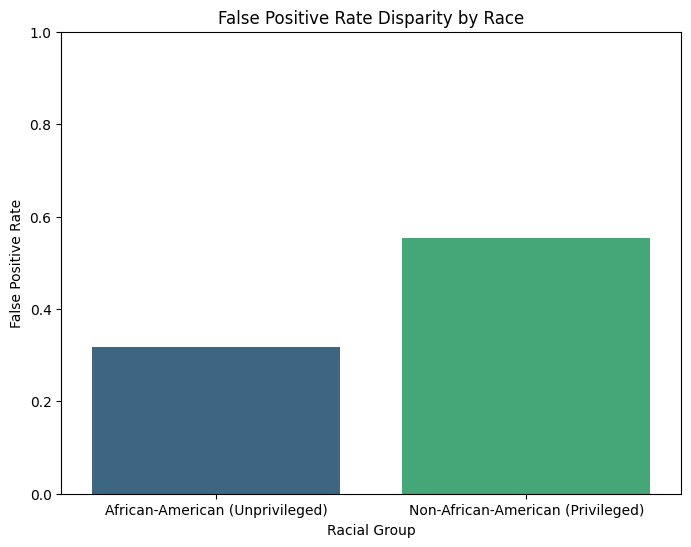

False Positive Rate disparity visualization generated.


In [40]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Racial Group', y='False Positive Rate', hue='Racial Group', data=df_fpr, palette='viridis', legend=False)
plt.title('False Positive Rate Disparity by Race')
plt.xlabel('Racial Group')
plt.ylabel('False Positive Rate')
plt.ylim(0, 1) # FPR is a rate, so it should be between 0 and 1
plt.show()
print("False Positive Rate disparity visualization generated.")

## Summary Report


The analysis reveals a significant disparity in False Positive Rates (FPR) between racial groups. The "Non-African-American (Privileged)" group exhibits a substantially higher False Positive Rate of **0.5534** compared to the "African-American (Unprivileged)" group, which has an FPR of **0.3171**. This results in a False Positive Rate Difference (Unprivileged - Privileged) of **-0.2363**. This means that Non-African-Americans are more often incorrectly classified as high risk for recidivism when they are not, compared to African-Americans.

### Data Analysis Key Findings

*   The COMPAS Recidivism Dataset was successfully loaded and preprocessed, including filtering for relevant cases, selecting key features, handling missing values, and one-hot encoding categorical variables.
*   An AIF360 `BinaryLabelDataset` was configured, identifying `race_African-American` as the protected attribute. The "Non-African-American" group (represented by `race_African-American = 0.0`) was designated as privileged, and the "African-American" group (`race_African-American = 1.0`) was designated as unprivileged.
*   The overall False Positive Rate for the "Non-African-American (Privileged)" group was **0.5534**.
*   The overall False Positive Rate for the "African-American (Unprivileged)" group was **0.3171**.
*   The difference in False Positive Rates (Unprivileged - Privileged) is **-0.2363**, indicating that the privileged group experiences a higher rate of false positives.

### Insights or Next Steps

*   The observed disparity, where Non-African-Americans have a significantly higher False Positive Rate, suggests that the COMPAS system might be over-predicting recidivism for this group compared to African-Americans. This highlights a fairness concern where individuals from the privileged group are more likely to be incorrectly labeled as high-risk, which could lead to harsher sentencing or supervision despite not re-offending.
*   Further investigation is warranted to understand the features contributing to this specific bias. Implementing bias mitigation techniques (e.g., reweighing, adversarial debiasing, or post-processing adjustments) and evaluating their impact on False Positive Rate parity while maintaining overall model performance would be a crucial next step.
